In [1]:
print("coucou")

coucou

In [2]:
using Polyhedra
using JuMP
using LinearAlgebra
using Gurobi #, Cbc, GLPK
using Plots
using LaTeXStrings

┌ Info: Precompiling Polyhedra [67491407-f73d-577b-9b50-8179a7c68029]
└ @ Base loading.jl:1278
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


In [3]:
include("../lib/julia/utils_MILP.jl")

getResultsALAP (generic function with 1 method)

In [4]:
# data of the problem
A=[0 1 0; 0 0 1; 1 0 0]
B=[1 0 0; 0 1 0; 0 0 1]
C=[1 0 0; 0 1 0]
k=[0; 0; 0]
N_m=4
N_c=4
T_max=10
alpha=4 # scaling of the safety set: alpha*hypercube

n_y,n_x=size(C)
_,n_u=size(B)

(3, 3)

In [5]:
time_beginning=time_ns()

model, C_bar, S = instantiateALAP(A,B,C,k,N_m,N_c,T_max,alpha);

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Instantiation time = $(exec_time) seconds ====\n\n")



==== Instantiation time = 18.927212522 seconds ====



In [6]:
set_optimizer(model, Gurobi.Optimizer)

time_beginning=time_ns()

optimize!(model)

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Solving time = $(exec_time) seconds ====\n\n")

Academic license - for non-commercial use only - expires 2021-03-07
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16811 rows, 7668 columns and 127562 nonzeros
Model fingerprint: 0xd4c741c0
Variable types: 7626 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 12820 rows and 4738 columns
Presolve time: 0.25s
Presolved: 3991 rows, 2930 columns, 30123 nonzeros
Found heuristic solution: objective 4.0000000
Variable types: 2900 continuous, 30 integer (30 binary)

Root relaxation: objective 1.100000e+01, 3505 iterations, 0.44 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [7]:
F, f, T_opt, sigma_meas_opt, sigma_control_opt = getResultsALAP(model,C_bar,S);
T_opt

7

In [8]:
"""
for t=0:T_max-1
    for tau=0:t
        if !sigma_meas_opt[tau+1]
            print("No meas. ")
        else
            print("Meas.    ")
        end
        if !sigma_control_opt[t+1]
            print("No cont. ")
        else
            print("Cont.    ")
        end
        print("f($t)=$(f[:,t+1]) ---  F($t,$(tau))=$(F[:,:,t+1,tau+1]) \n")
    end
end
"""

LoadError: UndefVarError: t not defined

In [9]:
x=simulateTrajectories(A,B,C,k,F,f;numberSamples=50);

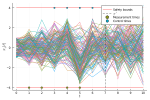

In [10]:
# plot trajectories
T=T_max
plot()
for component=1:size(x)[2]
    plot!(0:T,x[:,component,:]',label=false)
end

xlabel!(L"t")
ylabel!(L"x_i(t)")

plot!(0:T,ones(T+1)*alpha,linecolor=:red, label="Safety bounds")
plot!(0:T,-ones(T+1)*alpha,linecolor=:red, label=false)

plot!([T_opt T_opt]',[-alpha alpha]',linecolor=:black,label=L"T^*",linestyle = :dash)

t_meas=findall(sigma_meas_opt.==1).-1
scatter!(t_meas,-alpha*ones(length(t_meas)),label="Measurement times",marker=:hexagon)

t_control=findall(sigma_control_opt.==1).-1
scatter!(t_control,alpha*ones(length(t_control)),label="Control times")
xticks!(0:T)

#plot!(size=(250,250))
#savefig("FIGS/ALAP.pdf")
plot!()

# Greedy

In [11]:
time_beginning=time_ns()

model_greedy=greedyALAP(A,B,C,k,N_m,N_c,T_max,alpha);

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Solving time = $(exec_time) seconds ====\n\n")

Academic license - for non-commercial use only - expires 2021-03-07
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 16811 rows, 7668 columns and 127562 nonzeros
Model fingerprint: 0x09edcd52
Variable types: 7626 continuous, 42 integer (42 binary)
Coefficient statistics:
  Matrix range     [2e-01, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective -0.0000000
Presolve removed 12820 rows and 4738 columns
Presolve time: 0.31s
Presolved: 3991 rows, 2930 columns, 30123 nonzeros
Found heuristic solution: objective 4.0000000
Variable types: 2900 continuous, 30 integer (30 binary)

Root relaxation: objective 1.100000e+01, 3272 iterations, 0.37 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

In [12]:
F_greedy, f_greedy, T_greedy, sigma_meas_greedy, sigma_control_greedy=getResultsALAP(model_greedy,C_bar,S);
T_greedy

6

In [13]:
for t=0:T_max-1
    for tau=0:t
        if !sigma_meas_greedy[tau+1]
            print("No meas. ")
        else
            print("Meas.    ")
        end
        if !sigma_control_greedy[t+1]
            print("No cont. ")
        else
            print("Cont.    ")
        end
        print("f($t)=$(f[:,t+1]) ---  F($t,$(tau))=$(F[:,:,t+1,tau+1]) \n")
    end
end

No meas. No cont. f(0)=[0.0, -1.1546319456101628e-14, 1.1546319456101628e-14] ---  F(0,0)=[0.0 0.0; 0.0 0.0; 0.0 0.0] 
No meas. No cont. f(1)=[1.7917223260610626e-11, -1.1453060722033115e-11, 1.1453060722033115e-11] ---  F(1,0)=[0.0 0.0; 0.0 0.0; 0.0 0.0] 
No meas. No cont. f(1)=[1.7917223260610626e-11, -1.1453060722033115e-11, 1.1453060722033115e-11] ---  F(1,1)=[0.0 0.0; 0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(2)=[1.7917223260610626e-11, -1.1453060722033115e-11, 1.1453060722033115e-11] ---  F(2,0)=[0.0 0.0; 0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(2)=[1.7917223260610626e-11, -1.1453060722033115e-11, 1.1453060722033115e-11] ---  F(2,1)=[0.0 0.0; 0.0 0.0; 0.0 0.0] 
Meas.    Cont.    f(2)=[1.7917223260610626e-11, -1.1453060722033115e-11, 1.1453060722033115e-11] ---  F(2,2)=[0.0 0.0; 0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(3)=[0.0, 1.0000000000194698, 0.9999999999820828] ---  F(3,0)=[0.0 0.0; 0.0 0.0; 0.0 0.0] 
No meas. Cont.    f(3)=[0.0, 1.0000000000194698, 0.9999999999820828] ---  F(3,1)=

In [14]:
x_greedy=simulateTrajectories(A,B,C,k,F_greedy,f_greedy;numberSamples=50);

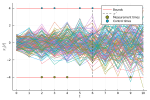

In [15]:
# plot trajectories
T=T_max
plot()
for component=1:size(x_greedy)[2]
    plot!(0:T,x_greedy[:,component,:]',label=false)
end

xlabel!(L"t")
ylabel!(L"x_i(t)")

plot!(0:T,ones(T+1)*alpha,linecolor=:red, label="Bounds")
plot!(0:T,-ones(T+1)*alpha,linecolor=:red, label=false)

plot!([T_greedy T_greedy]',[-alpha alpha]',linecolor=:black,label=L"T^*",linestyle = :dash)

t_meas=findall(sigma_meas_greedy.==1).-1
scatter!(t_meas,-alpha*ones(length(t_meas)),label="Measurement times",marker=:hexagon)

t_control=findall(sigma_control_greedy.==1).-1
scatter!(t_control,alpha*ones(length(t_control)),label="Control times")
xticks!(0:T)

#plot!(size=(250,250))
#savefig("FIGS/ALAP_greedy.pdf")
plot!()

In [16]:
T_opt

7

In [17]:
T_greedy

6

# Binary Search

In [18]:
time_beginning=time_ns()

ASAPmodel,T_BS,current_alpha=binarySearchALAP(A,B,C,k,N_m,N_c,T_max,alpha)

time_ending=time_ns()
exec_time=(time_ending-time_beginning)/1e9
print("\n\n==== Solving time = $(exec_time) seconds ====\n\n")

Academic license - for non-commercial use only - expires 2021-03-07
Gurobi Optimizer version 9.1.0 build v9.1.0rc0 (mac64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 333 rows, 204 columns and 681 nonzeros
Model fingerprint: 0x71667642
Variable types: 202 continuous, 2 integer (2 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 321 rows and 182 columns
Presolve time: 0.00s
Presolved: 12 rows, 22 columns, 48 nonzeros
Variable types: 22 continuous, 0 integer (0 binary)

Root relaxation: objective 2.000000e+00, 5 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       2.0000000    2.00000  0.00%     -    0s

Explored 0 nodes (5 simplex iterations) i

In [19]:
T_opt

7

In [20]:
T_greedy

6

In [21]:
T_BS

7